**Imports**

In [2]:
from __future__ import division
import scipy.constants as const
import math
import scipy
from scipy.io import wavfile
from IPython.core.display import HTML
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal 
%matplotlib inline


**Constants, defaults, etc.**

Sampling rate set to 44.1KHz

Number of unique notes set to 88 (source: wikipedia)

In [3]:
rate = 44100 #44.1 khz
key2freq = lambda n : 2 ** ((n+1-49)/12) * 440 # convert a piano key n to a frequency in Hz
num_notes = 88

# Bi-directional mapping between keys and frequencies
key2frequency = {i : key2freq(i) for i in range(88)}
frequency2key = {key2frequency[key] : key for key in key2frequency}
print(key2frequency)

{0: 27.5, 1: 29.13523509488062, 2: 30.86770632850775, 3: 32.70319566257483, 4: 34.64782887210901, 5: 36.70809598967594, 6: 38.890872965260115, 7: 41.20344461410875, 8: 43.653528929125486, 9: 46.2493028389543, 10: 48.999429497718666, 11: 51.91308719749314, 12: 55.0, 13: 58.27047018976124, 14: 61.7354126570155, 15: 65.40639132514966, 16: 69.29565774421802, 17: 73.41619197935188, 18: 77.78174593052023, 19: 82.4068892282175, 20: 87.30705785825097, 21: 92.4986056779086, 22: 97.99885899543733, 23: 103.82617439498628, 24: 110.0, 25: 116.54094037952248, 26: 123.47082531403103, 27: 130.8127826502993, 28: 138.59131548843604, 29: 146.8323839587038, 30: 155.56349186104046, 31: 164.81377845643496, 32: 174.61411571650194, 33: 184.9972113558172, 34: 195.99771799087463, 35: 207.65234878997256, 36: 220.0, 37: 233.08188075904496, 38: 246.94165062806206, 39: 261.6255653005986, 40: 277.1826309768721, 41: 293.6647679174076, 42: 311.1269837220809, 43: 329.6275569128699, 44: 349.2282314330039, 45: 369.994422

** Output **

Playing the actual music

In [4]:
# this is a wrapper that take a filename and publish an html <audio> tag to listen to it
def wavPlayer(filepath):
    src = """
    <head>
    <meta http-equiv="Content-Type" content="text/html; charset=utf-8">
    <title>Simple Test</title>
    </head>
    <body>
    <audio controls="controls" style="width:600px" >
      <source src="files/%s" type="audio/wav" />
      Your browser does not support the audio element.
    </audio>
    </body>
    """%(filepath)
    display(HTML(src))
    
def playMusic(title, rate, music):
    # write the file on disk, and show in in a Html 5 audio player
    music_wav = music * 2**13
    wavfile.write(title + '.wav', rate, music_wav.astype(np.int16))
    wavPlayer(title + '.wav')

** LOGIC **

Implementing the Markov model

In [5]:
def song_from_notes(notes, note_duration):
    """Converts a list of notes into a playable song"""
    
    #note_duration = 0.5 # per key, in sec
    music_duration = note_duration * len(notes)
    time = np.linspace(0, music_duration, num=rate*music_duration) # indices for 0-16 secs spaced apart by 1/44100
    song = np.zeros(len(time))

    sinwave = lambda f,t : np.sin(2*np.pi*f*t) # generate a sinusoid of frequency f Hz over time t

    idx_note = 0
    for note in notes:
        if note: # if note == 0, skip.
            freq = key2freq(note) # frequency of each note
            song[idx_note*rate*note_duration : (idx_note+1)*rate*note_duration-1] = \
                    sinwave(freq,
                            time[idx_note*rate*note_duration : (idx_note+1)*rate*note_duration-1 ] 
                            ) #generates the sinusoids for the song, in .5 sec intervals
        idx_note += 1
        
    return song

In [20]:
def notes_from_wav(wav_file):
    """Converts a wav file to a list of notes"""
    rate, data = scipy.io.wavfile.read(wav_file)
    show_info(wav_file, data)
    freqs = convert_signal_to_freqs(data, rate)
    formatted_freqs = nearest_piano_freq(freqs, list(key2frequency.values()))
    notes = [frequency2key[freq] for freq in formatted_freqs]
    return notes

def show_info(aname, a):
    print( "Array", aname)
    print( "shape:", a.shape)
    print( "dtype:", a.dtype)
    print( "min, max:", a.min(), a.max())

def convert_signal_to_freqs(data, rate):
    t = np.linspace(0, (len(data)-1)/rate, len(data))
    song = (data[:, 1] + data[:,0])/2
    
    note_length = 0.198
    window_size = note_length * rate
    print("note length:%f" %note_length)
    num_windows = math.ceil(len(song)/window_size)
    
    ffts = []
    bins = []
    freq_lists = []
    f = lambda x :np.linspace(-0.5*rate, 0.5*rate, x)
    tx = lambda x :np.linspace(0, note_length, x)

    i = 0
    while i < len(t):
        if i+window_size >= len(t):
            curr_fft = np.fft.fft(song[i:])
            curr_bin = song[i:]
        else:
            curr_fft = np.fft.fftshift(abs(np.fft.fft(song[i:i+window_size])))
            curr_bin = song[i:i+window_size]
        freqs = f(len(curr_fft))
        highestMagIndices = np.where(curr_fft == max(curr_fft))
        curr_freq = abs(freqs[highestMagIndices[0][0]])
        freq_lists.append(curr_freq)
        ffts.append(curr_fft)
        bins.append(curr_bin)
        i += window_size

    filtered_list = [freq for freq in freq_lists if freq > 25 and freq < 4200]
    print( len(filtered_list))
    
    assert num_windows == len(ffts)
    index = 30
    plt.figure()
    plt.plot(f(len(ffts[index])), ffts[index])
    plt.figure()
    plt.plot(tx(len(bins[index])), bins[index])
    return filtered_list

def nearest_piano_freq(freqs, standard_freqs):
    formatted_freqs = []
    for freq in freqs:
        check_list = [abs(f - freq) for f in standard_freqs]
        min_index = check_list.index(min(check_list))
        formatted_freqs.append(standard_freqs[min_index])
    return formatted_freqs

In [21]:
def stochastic_matrix(*note_lists, **kwargs):
    """Calculates the stochastic matrix from all of the note lists
    and for a Markov model of the given degree"""
    
    degree = kwargs['degree']
    matrix = np.zeros((num_notes**degree, num_notes))
    
    for notes in note_lists:
        print len(notes)
        print len(note_lists)
        for i in range(len(notes)):
            curr_note_sequence = notes[i:i+degree]
            # Calculate the index
            curr_seq_index = notes2index(curr_note_sequence)
            if i < len(notes)-degree:
                # Get next note
                next_note = notes[i+degree]
                matrix[curr_seq_index][next_note] += 1
      
    return normalize(matrix)

def normalize(matrix):
    """Normalizes matrix rows"""
    
    row_sums = matrix.sum(axis=1)
    matrix = matrix / row_sums[:, np.newaxis]
    return matrix
    
def notes2index(note_sequence):
    """Calculates the index of the stochastic matrix for the given sequence of notes,
    generalized to n notes. Does this by mapping base-88 to base-10"""
    return sum([note_sequence[i]*(88**i) for i in range(len(note_sequence)-1, -1, -1)])

# notes = notes_from_wav("fur_elise.wav")
# notes = [1, 2, 3, 4, 1]
# matrix = stochastic_matrix(notes, degree=1)
notes = [47, 47, 49, 49, 47, 47, 49, 48]
test = stochastic_matrix(notes, degree=2)
print(len(test))

8
1
7744


/Users/Adesoji/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in true_divide


In [22]:
def random_walk(stoch_matrix, size, notes, initial_note=440, degree=1):
    
    # You can use the degree passed in to group notes
    # You can look up the value in the stochastic matrix by calling notes2index on a list of notes
    # For example: notes2index([46 47]) will give you the index of that element in the stochastic matrix
    converted_note = notes2index(initial_note)
    distribution = stoch_matrix[converted_note]
    result = np.array([initial_note])
    upper_bound = len(stoch_matrix)
    for i in range(1, size):
        x = np.sum(distribution)
        if np.isnan(x):
            next_val = np.random.choice(np.arange(0,len(stoch_matrix[0])))
            while next_val not in notes:
                next_val = np.random.choice(np.arange(0,len(stoch_matrix[0])))
            result = np.append(result, next_val)
            distribution = stoch_matrix[next_val]
        else:
            next_val = np.random.choice(np.arange(0,len(stoch_matrix[0])), 1, p = distribution)
            result = np.append(result, next_val)
            distribution = stoch_matrix[next_val[0]]
    return result

generated_song_notes = random_walk(test, len(notes), notes, initial_note=[47,49], degree=2)
playMusic("hi", rate, song_from_notes(generated_song_notes, 0.2))
playMusic("new", rate, song_from_notes(notes, 0.2))
print(generated_song_notes)

/Users/Adesoji/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[47 49 49 48 47 47 48 47 49]


**MAIN**

Putting everything together

('Array', 'minuet_in_g_major.wav')
('shape:', (4526208, 2))
('dtype:', dtype('int16'))
('min, max:', -28474, 21448)
note length:0.198000

/Users/Adesoji/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:37: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Adesoji/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:38: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



490
('Array', 'fur_elise.wav')
('shape:', (7713792, 2))
('dtype:', dtype('int16'))
('min, max:', -20017, 17591)
note length:0.198000
850
('Array', 'symphony_in_am.wav')
('shape:', (10119168, 2))
('dtype:', dtype('int16'))
('min, max:', -23493, 19751)
note length:0.198000
1121
('Array', 'air_on_the_g_string.wav')
('shape:', (3962880, 2))
('dtype:', dtype('int16'))
('min, max:', -27482, 25738)
note length:0.198000
439


/Users/Adesoji/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:34: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Adesoji/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:35: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


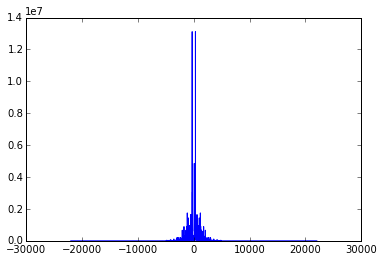

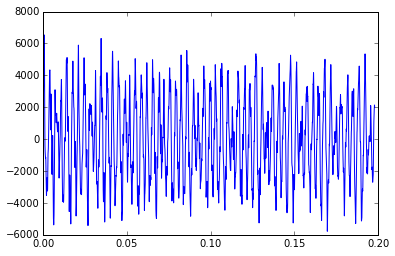

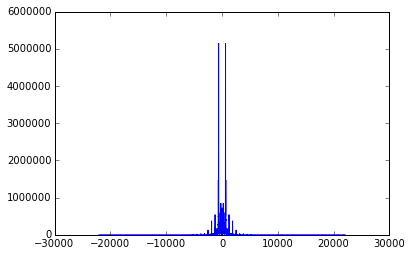

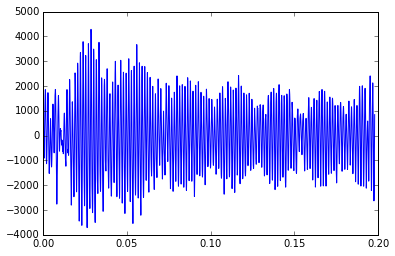

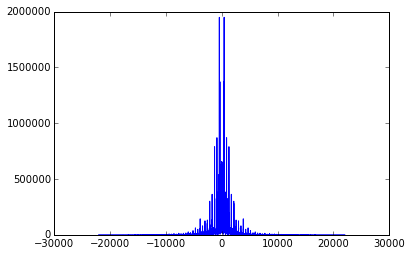

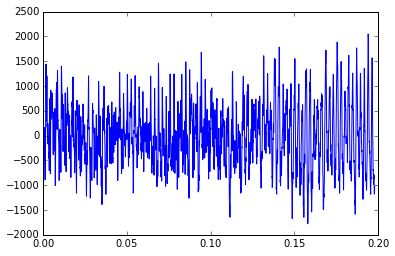

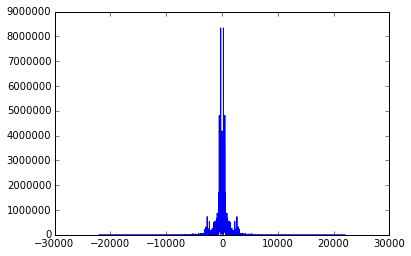

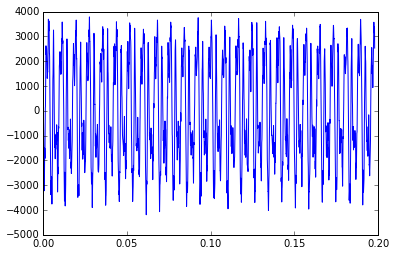

In [23]:
# Get notes from wav
notes = notes_from_wav("minuet_in_g_major.wav")
wav_list = ["fur_elise.wav", "symphony_in_am.wav", "air_on_the_g_string.wav"]
#notes_list = [notes_from_wav(wav) for wav in wav_list]

notes1 = notes_from_wav(wav_list[0])
notes2 = notes_from_wav(wav_list[1])
notes3 = notes_from_wav(wav_list[2])


In [24]:
# Calculate stochastic matrix
matrix = stochastic_matrix(notes, notes1, notes2, notes3, degree=2)

490
4
850
4
1121
4
439
4


/Users/Adesoji/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in true_divide


In [25]:
# Create a random walk of notes, starting from a particular note
generated_song_notes = random_walk(matrix, len(notes), notes, initial_note=[notes[0], notes[1]], degree=2)


# play song notes!
playMusic("orig", rate, song_from_notes(notes, 0.2))
playMusic("generated", rate, song_from_notes(generated_song_notes, 0.2))
 

/Users/Adesoji/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


400
400
True


/Users/Adesoji/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(0.0, 0.01, 2, -2)

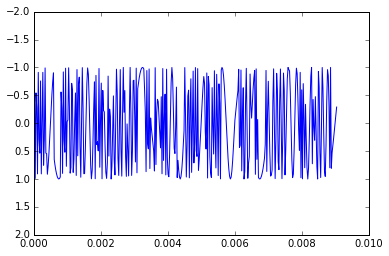

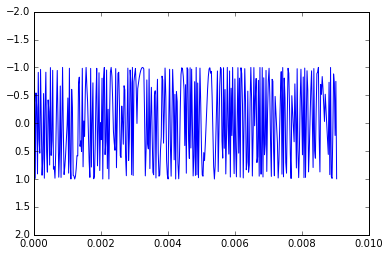

In [53]:
song = song_from_notes(notes, 0.2)
song = song[0:800000:2000]
print len(song)
gen_song = song_from_notes(generated_song_notes, 0.2)
gen_song = gen_song[0:800000:2000]
print len(gen_song)
print len(gen_song) == len(song)
song_t = np.linspace(0, (len(song)-1)/rate, len(song))
gen_song_t = np.linspace(0, (len(gen_song)-1)/rate, len(gen_song))

plt.figure()
plt.plot(song_t, song)
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,2,-2))
plt.figure()
plt.plot(gen_song_t, gen_song)
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,2,-2))